# `kissim`-based kinome tree

We generate `kissim`-based kinome matrices and trees based on for the 20210812 runs.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
from Bio import Phylo
from opencadd.databases.klifs import setup_remote
from IPython.display import display, Markdown

from kissim.comparison import FingerprintDistanceGenerator
from kissim.comparison import matrix, tree

In [3]:
matplotlib.rc("font", size=6)

In [4]:
# Set path to this notebook
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results_archive"

In [5]:
# Set bit coverage between fingerprint pairs
COVERAGE_MIN = 0.8
RUN_IDS = ["20210812-1", "20210812-2"]
WEIGHTING_SCHEMES = ["15", "110", "101", "100"]
DFG_CONFORMATIONS = ["in"]
CLUSTERING_METHODS = ["ward", "average", "weighted"]
FIG_HEIGHT = {"all": 25, "in": 25, "out": 10}

## Data

- 20210630 KLIFS download
- With 3 pocket mutations onnly and resolution <= 3A
- DFG-in
- Different `kissim` setups:
  - 20210812-1: Normalized fingerprint + all residues
  - 20210812-2: Normalized fingerprint + subset of residues

## Kinase-color mapping

In [6]:
klifs_session = setup_remote()
kinases = klifs_session.kinases.all_kinases(species="Human")
kinases = klifs_session.kinases.by_kinase_klifs_id(kinases["kinase.klifs_id"].to_list())
kinases = kinases[["kinase.klifs_name", "kinase.group"]]
kinase_groups = kinases["kinase.group"].sort_values().unique()
colors = [
    "red",
    "orange",
    "yellowgreen",
    "limegreen",
    "turquoise",
    "cornflowerblue",
    "grey",
    "mediumblue",
    "darkorchid",
    "violet",
]
groups_to_color = {g: c for g, c in zip(kinase_groups, colors)}
kinases["color"] = kinases["kinase.group"].apply(lambda x: groups_to_color[x])
label_colors = kinases.set_index("kinase.klifs_name")["color"].to_dict()
LABEL_COLORS = label_colors

## Helper functions

In [7]:
def generate_trees(
    path_results=RESULTS,
    run_ids=RUN_IDS,
    weighting_schemes=WEIGHTING_SCHEMES,
    dfg_conformations=DFG_CONFORMATIONS,
    clustering_methods=CLUSTERING_METHODS,
    coverage_min=COVERAGE_MIN,
):
    def _load_fingerprint_distances(path_results, weighting):
        """
        Load fingerprint distances (all conformations).
        """

        if weighting == "15":
            filepath = path_results / "fingerprint_distances.csv"
        else:
            filepath = path_results / f"fingerprint_distances_{weighting}.csv"
        fingerprint_distances = FingerprintDistanceGenerator.from_csv(filepath)

        return fingerprint_distances.data

    def _generate_distance_matrix(distances, coverage_min, weighting, path):
        """
        Generate and save distance matrix.
        """
        distance_matrix = matrix.kinase_distance_matrix(
            distances,
            by="minimum",
            fill_diagonal=True,
            coverage_min=coverage_min,
        )
        distance_matrix.to_csv(path / f"kinase_matrix_{coverage_min}_{weighting}.csv")
        return distance_matrix

    def _generate_tree(distance_matrix, weighting, cmethod, coverage_min, path):
        """
        Generate and save tree.
        """
        tree.from_distance_matrix(
            distance_matrix,
            path / f"tree_{coverage_min}_{weighting}_{cmethod}.tree",
            clustering_method=cmethod,
        )

    for run_id in run_ids:
        for dfg in dfg_conformations:
            path = path_results / f"{run_id}/dfg_{dfg}"
            print(path)
            (path / "matrices").mkdir(parents=True, exist_ok=True)
            (path / "trees").mkdir(parents=True, exist_ok=True)

            for weighting in weighting_schemes:
                distances = _load_fingerprint_distances(path, weighting)
                distance_matrix = _generate_distance_matrix(
                    distances, coverage_min, weighting, path / "matrices"
                )
                for cmethod in clustering_methods:
                    print(f"{weighting}_{dfg}_{cmethod}_{coverage_min}")
                    _generate_tree(
                        distance_matrix, weighting, cmethod, coverage_min, path / "trees"
                    )

In [8]:
def visualize_trees(
    path_results=RESULTS,
    run_ids=RUN_IDS,
    weighting_schemes=WEIGHTING_SCHEMES,
    dfg_conformations=DFG_CONFORMATIONS,
    clustering_methods=CLUSTERING_METHODS,
    fig_height=FIG_HEIGHT,
    label_colors=LABEL_COLORS,
    coverage_min=COVERAGE_MIN,
):
    for run_id in run_ids:
        display(Markdown(f"## Run {run_id}"))
        for weighting in weighting_schemes:
            display(Markdown(f"### Weighing {weighting}"))
            for dfg in dfg_conformations:
                for cmethod in clustering_methods:
                    display(Markdown(f"##### {cmethod}"))
                    path_newick = (
                        path_results
                        / f"{run_id}/dfg_{dfg}/trees"
                        / f"tree_{coverage_min}_{weighting}_{cmethod}.tree"
                    )
                    kissim_tree = Phylo.read(path_newick, "newick")
                    kissim_tree.ladderize()  # Flip branches so deeper clades are displayed at top

                    fig, ax = plt.subplots(1, 1, figsize=(5, fig_height[dfg]))
                    ax.set_title(
                        f"weighting {weighting} | DFG-{dfg} "
                        f"| cmethod {cmethod} | {kissim_tree.count_terminals()} leafs"
                    )
                    Phylo.draw(kissim_tree, axes=ax, label_colors=label_colors)

In [9]:
%%time
generate_trees()

/home/dominique/Documents/GitHub/kissim_app/notebooks/007_kissim_setups/../../results_archive/20210812-1/dfg_in
15_in_ward_0.8
15_in_average_0.8
15_in_weighted_0.8
110_in_ward_0.8
110_in_average_0.8
110_in_weighted_0.8
101_in_ward_0.8
101_in_average_0.8
101_in_weighted_0.8
100_in_ward_0.8
100_in_average_0.8
100_in_weighted_0.8
/home/dominique/Documents/GitHub/kissim_app/notebooks/007_kissim_setups/../../results_archive/20210812-2/dfg_in
15_in_ward_0.8
15_in_average_0.8
15_in_weighted_0.8
110_in_ward_0.8
110_in_average_0.8
110_in_weighted_0.8
101_in_ward_0.8
101_in_average_0.8
101_in_weighted_0.8
100_in_ward_0.8
100_in_average_0.8
100_in_weighted_0.8
CPU times: user 3min 29s, sys: 14.2 s, total: 3min 43s
Wall time: 3min 43s


## Run 20210812-1

### Weighing 15

##### ward

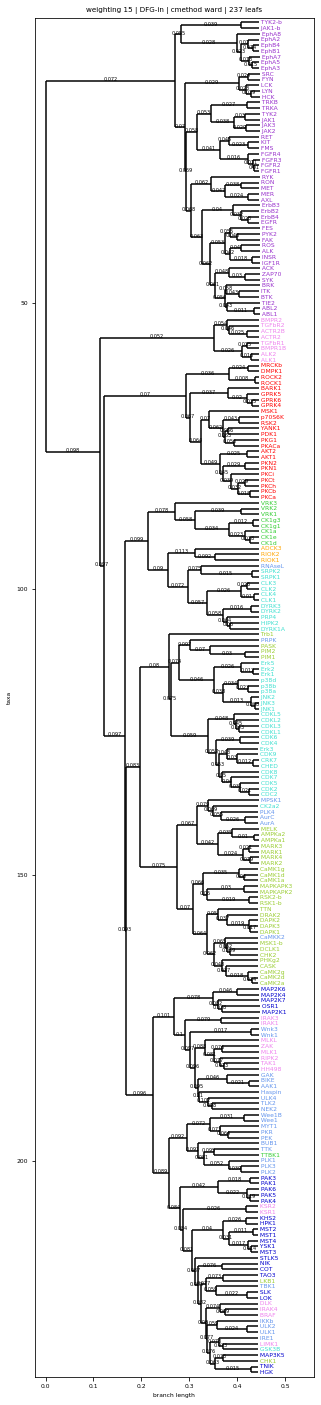

##### average

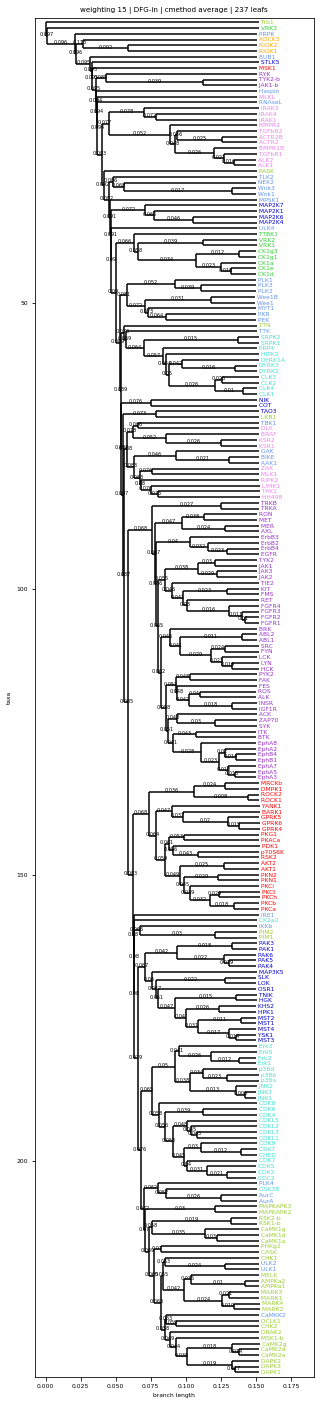

##### weighted

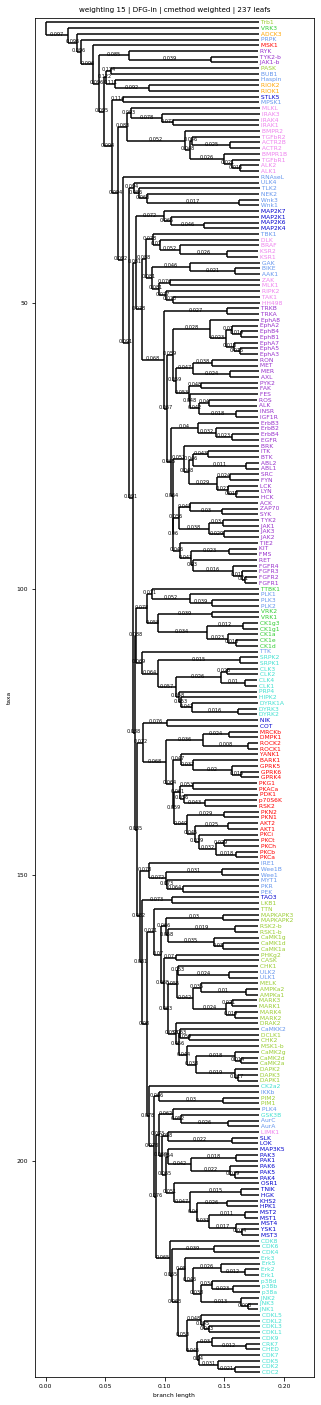

### Weighing 110

##### ward

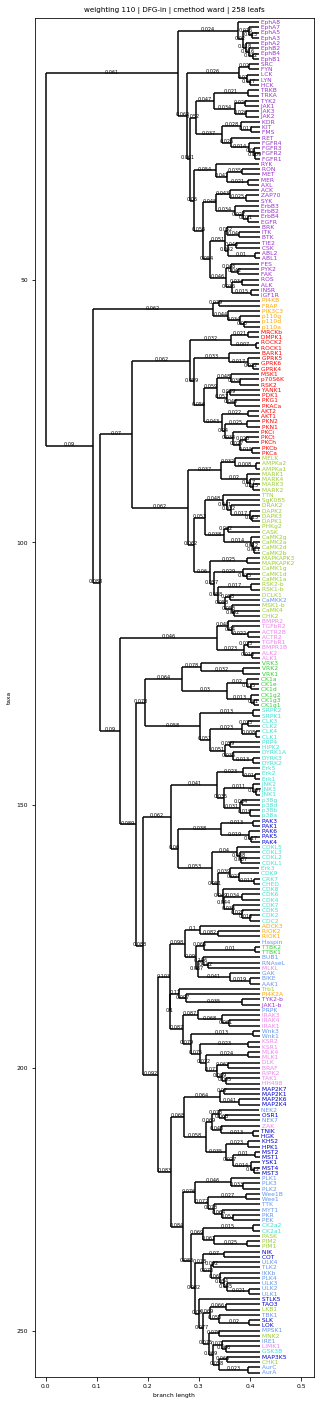

##### average

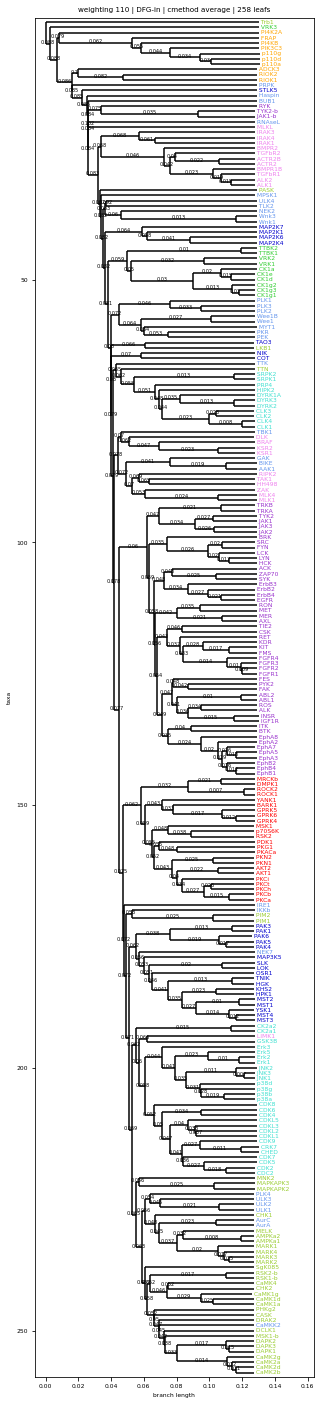

##### weighted

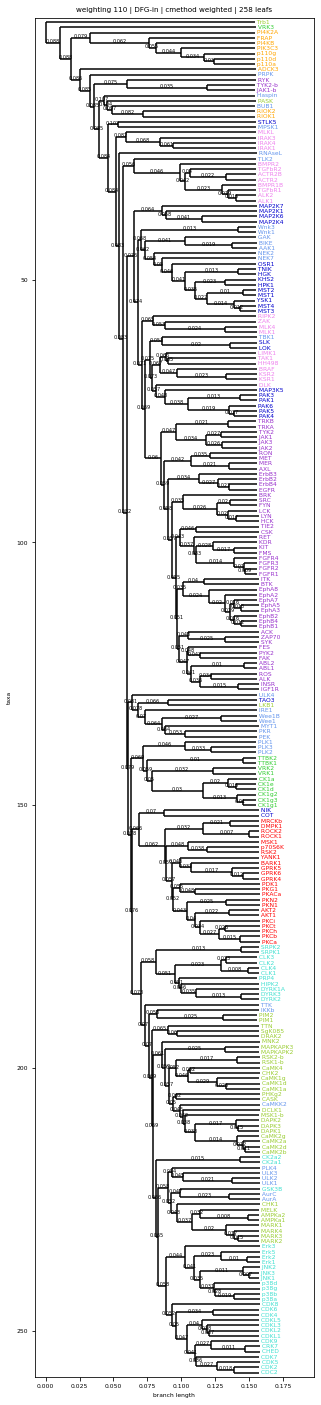

### Weighing 101

##### ward

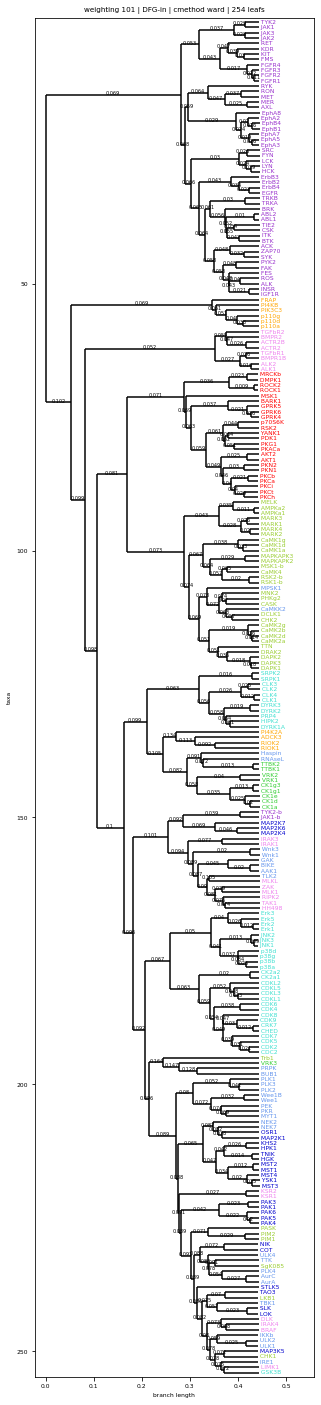

##### average

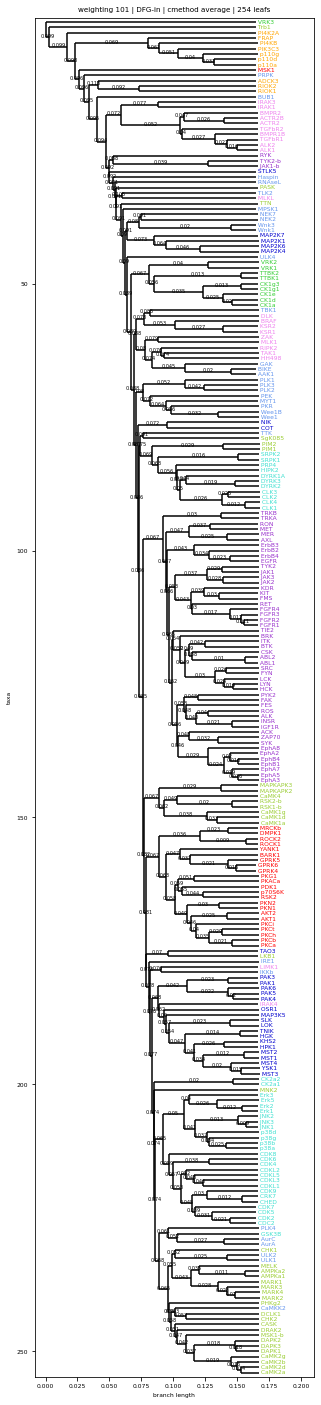

##### weighted

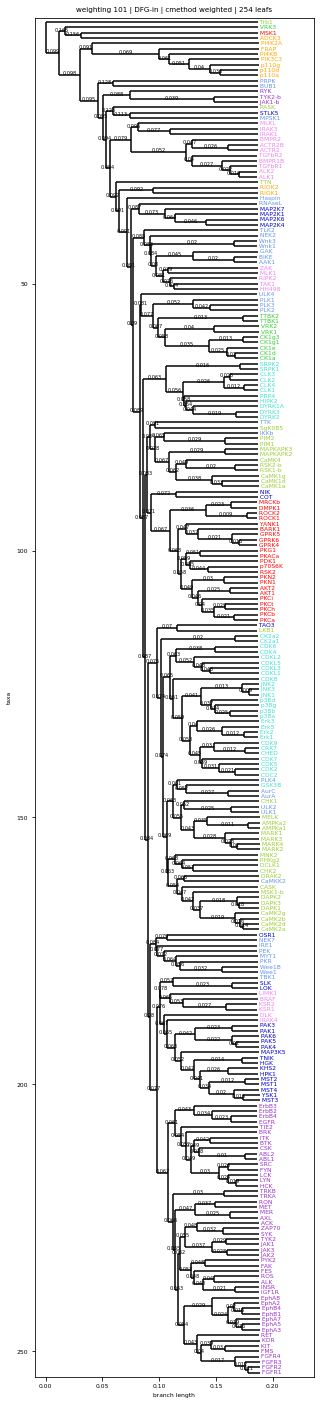

### Weighing 100

##### ward

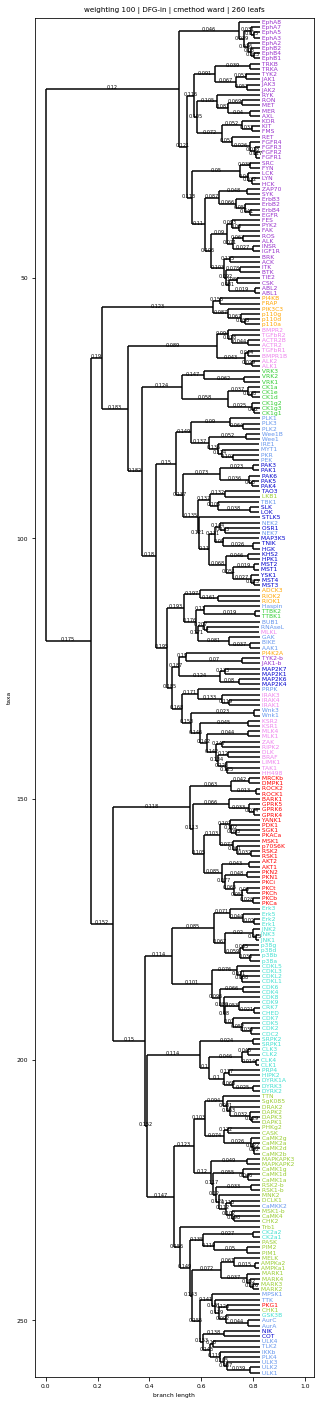

##### average

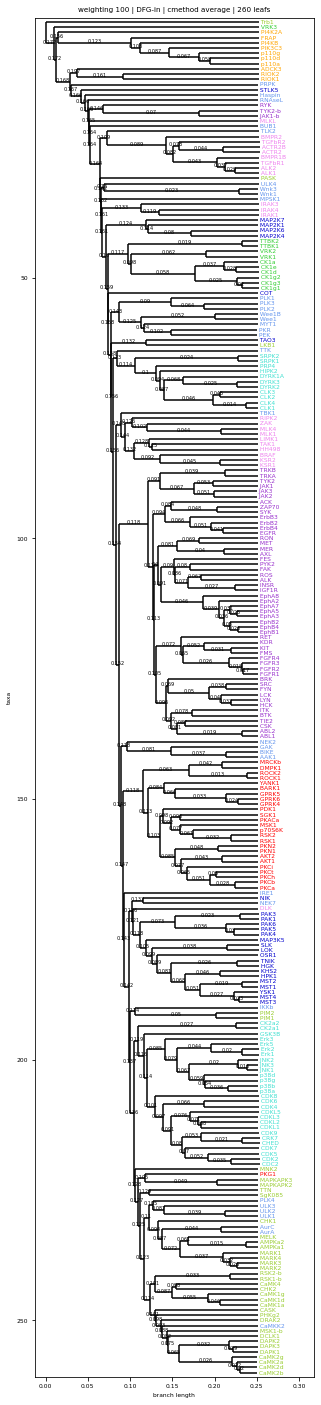

##### weighted

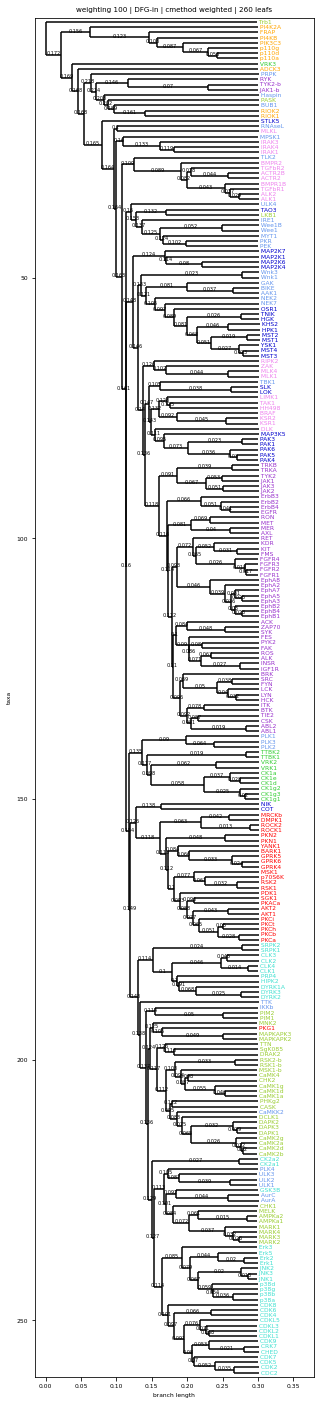

## Run 20210812-2

### Weighing 15

##### ward

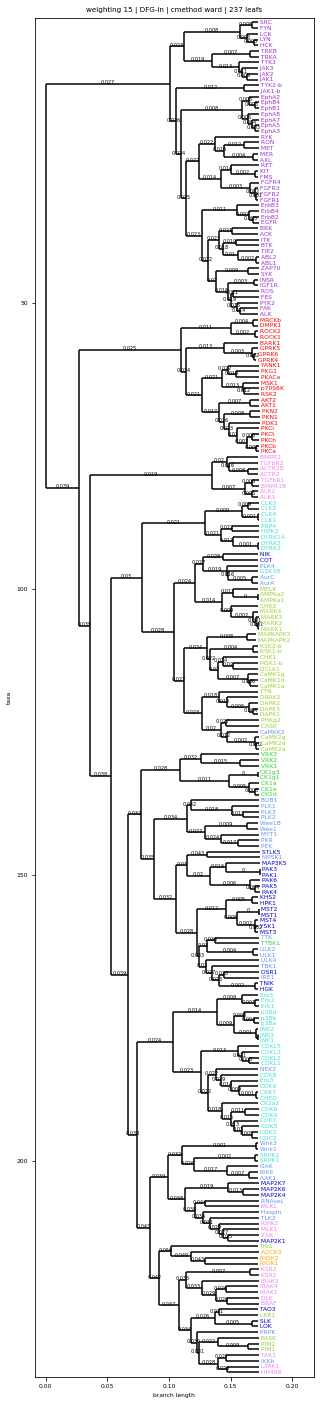

##### average

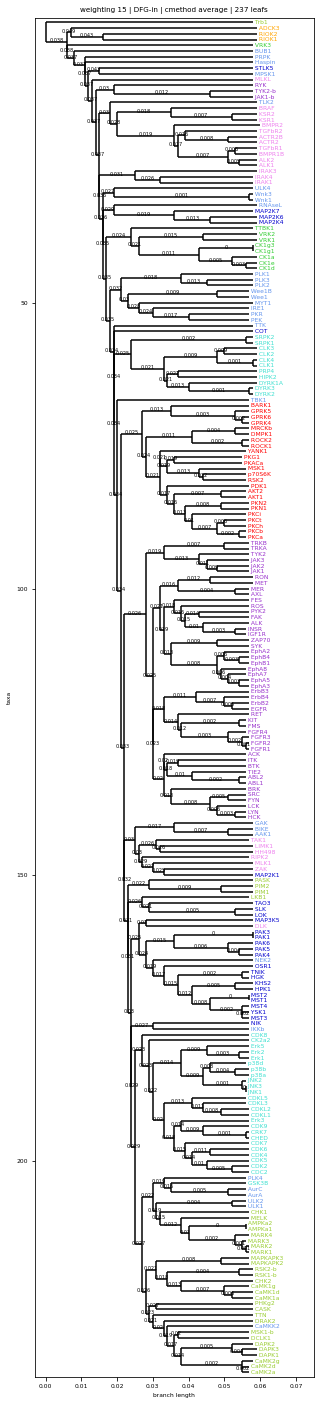

##### weighted

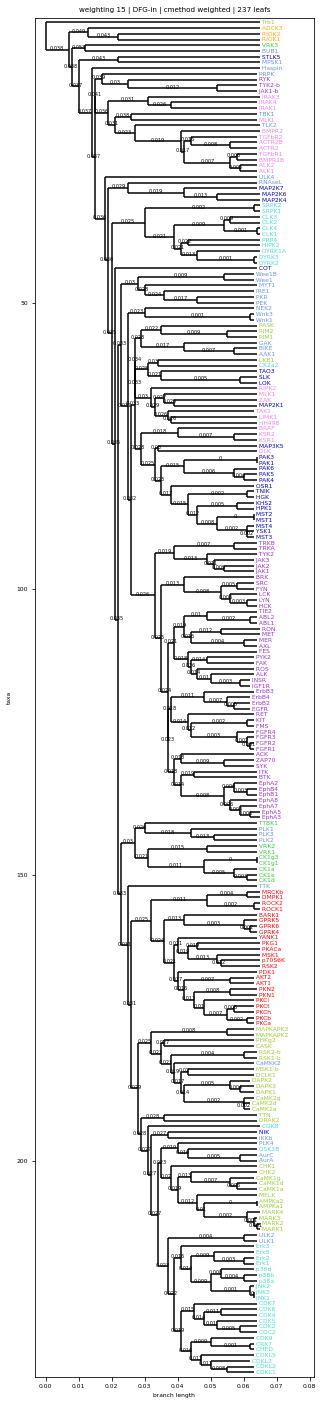

### Weighing 110

##### ward

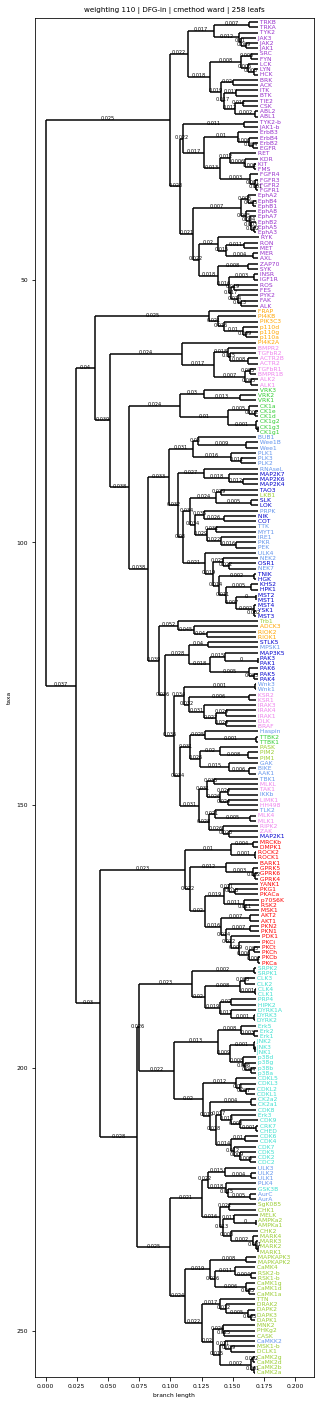

##### average

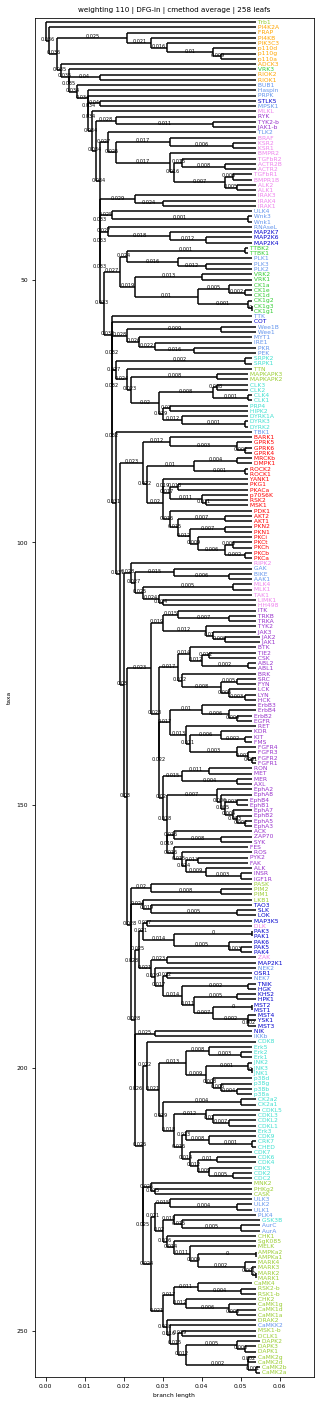

##### weighted

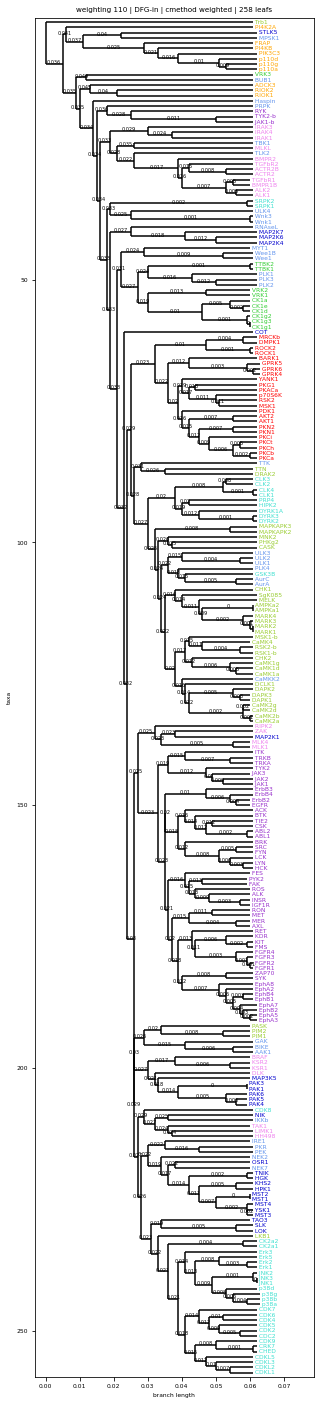

### Weighing 101

##### ward

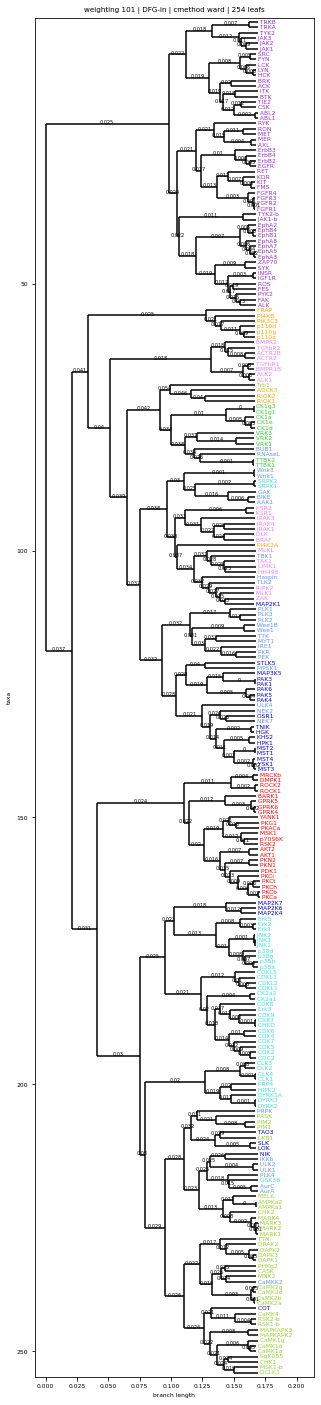

##### average

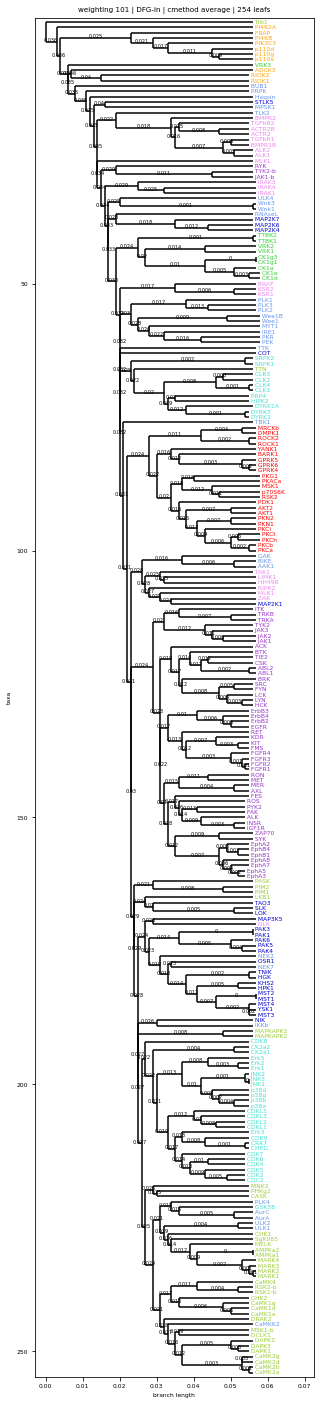

##### weighted

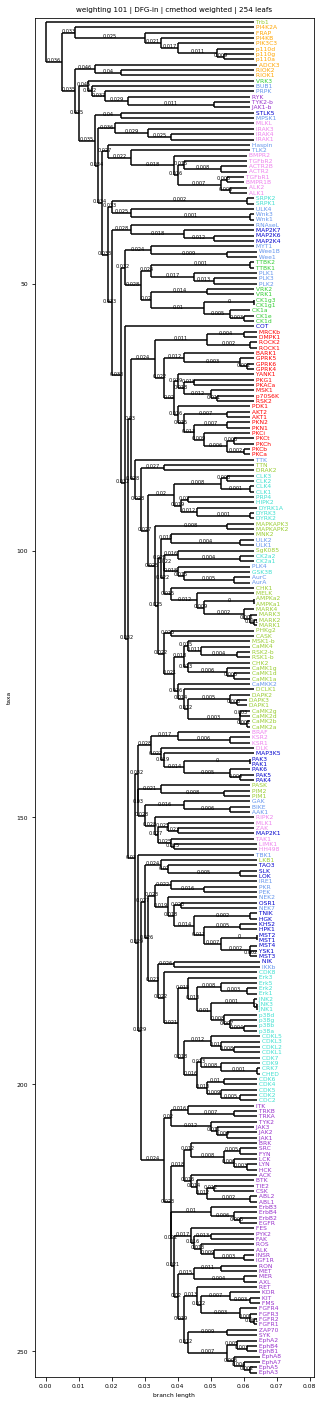

### Weighing 100

##### ward

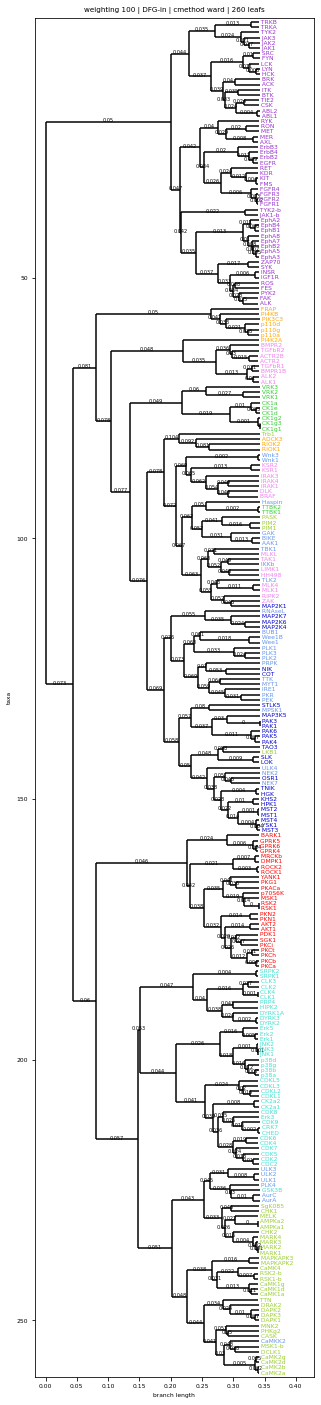

##### average

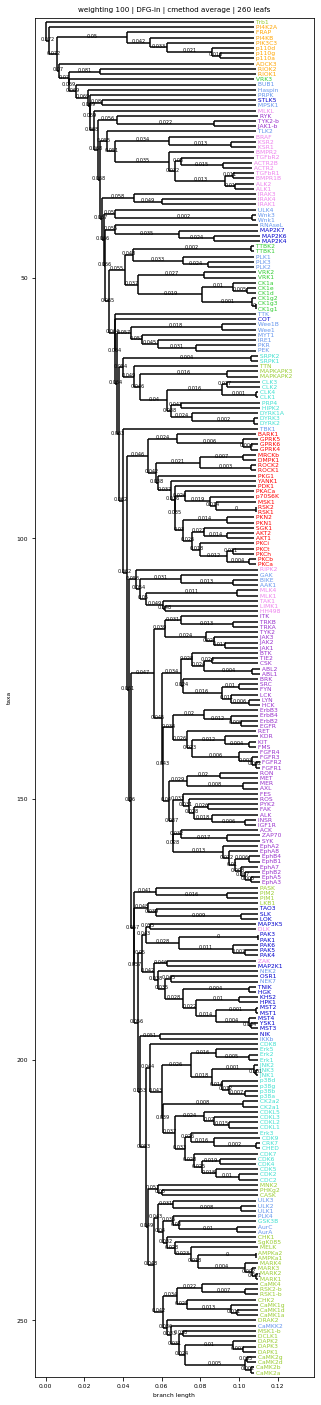

##### weighted

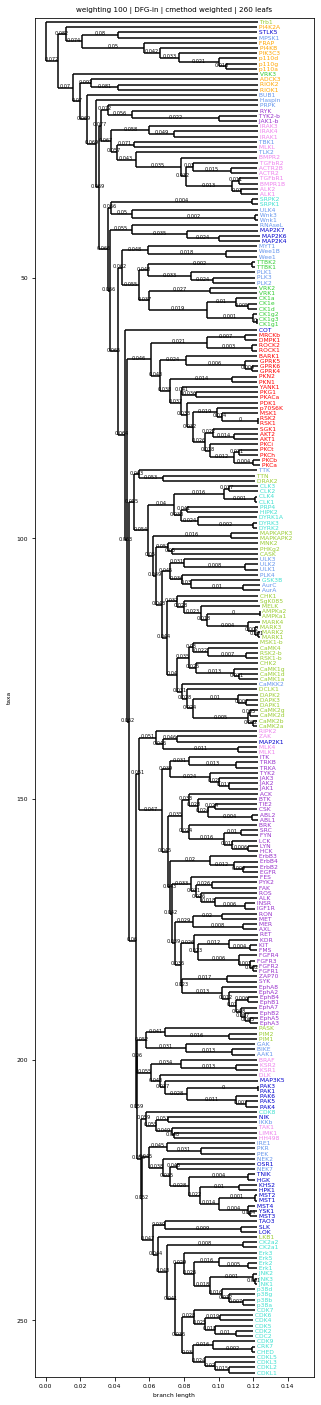

CPU times: user 41.2 s, sys: 1.38 s, total: 42.5 s
Wall time: 42.5 s


In [10]:
%%time
visualize_trees()